# Importing all necessary modules

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Downloading mnist data from keras API

In [17]:
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

Function to convert grey scale image into rgb image

In [18]:
def create(x,y):
    a=np.random.randint(0,2)
    image=0.5*np.random.rand(28,28,3)
    image[:,:,a] +=0.5*x/255
    return image,y,a

we are using dictionary to keep track of the colours and displaying the digits and their respective colours by plot.imshow() function

digit:0, colour:green 


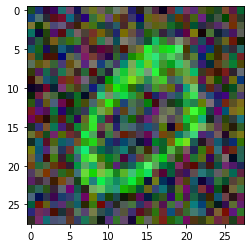

In [19]:
colours={0:'red',1:'green'}
x,y,a=create(x_train[1],y_train[1])
print(f'digit:{y}, colour:{colours[a]} ')

plt.imshow(x)
plt.show()

# Dataset Generation

Now we generate our data by converting them into rgb pixel images from grey scale images

In [20]:
def generate_data(x,y,batch_size=32):
    num_examples=len(y)
    
    while (True):
        x_batch=np.zeros((batch_size,28,28,3))
        y_batch=np.zeros((batch_size))
        c_batch=np.zeros((batch_size))
        
        for i in range(0,batch_size):
            index=np.random.randint(0,num_examples)
            image,digit,colour=create(x[index],y[index])
            x_batch[i]=image
            y_batch[i]=digit
            c_batch[i]=colour
        yield x_batch, [y_batch,c_batch]

In [21]:
x,[y,c]=next(generate_data(x_test,y_test,batch_size=1))

[2.] [1.]


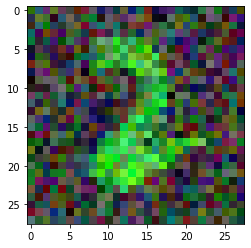

In [22]:
print(y,c)
plt.imshow(x[0])
plt.show()

# creating CNN model

In [23]:
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPool2D,Flatten,Add,Dense

In [24]:
input=Input(shape=(28,28,3))

#here we are building network for colour classification and sucessively another set of layers for second classification that is digit classification
conv1=Conv2D(32,3,name='conv1')(input)
act1=Activation('relu',name='act1')(conv1)
pool1=MaxPool2D(4,name='pool1')(act1)
flat1=Flatten(name='flat1')(pool1)
colour=Dense(1,activation='sigmoid',name='colour')(flat1)

conv2=Conv2D(32,3,name='conv2',padding='same')(act1)
act2=Activation('relu',name='act2')(conv2)
conv3=Conv2D(32,3,name='conv3',padding='same')(act2)
#We are using skip connection here just slightly to denote resnet architecture, however this may not be needed for these simple datasets.
add=Add(name='add')([act1,conv3])
act3=Activation('relu',name='act3')(conv3)

pool2=MaxPool2D(4,name='pool2')(act3)
flat2=Flatten(name='flat2')(pool2)
digit=Dense(10,activation='sigmoid',name='digit')(flat2)
model=tf.keras.models.Model(input,[digit,colour])

In [25]:
model.compile(loss={'digit':'sparse_categorical_crossentropy','colour':'binary_crossentropy'},metrics=['accuracy'],optimizer='adam')

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 28, 28, 3)]  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 26, 26, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
act1 (Activation)               (None, 26, 26, 32)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 26, 26, 32)   9248        act1[0][0]                       
____________________________________________________________________________________________

# Training Model

In [46]:
train_gen=generate_data(x_train,y_train)
test_gen=generate_data(x_test,y_test)
history=model.fit_generator(train_gen,validation_data=test_gen,steps_per_epoch=200,validation_steps=100,epochs=10)
                       

Epoch 1/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0830 - digit_loss: 0.0830 - colour_loss: 5.9880e-05 - digit_acc: 0.9747 - colour_acc: 1.0000 - val_loss: 0.0886 - val_digit_loss: 0.0885 - val_colour_loss: 4.7227e-05 - val_digit_acc: 0.9716 - val_colour_acc: 1.0000
Epoch 2/10
200/200 [==============================] - 16s 81ms/step - loss: 0.0852 - digit_loss: 0.0851 - colour_loss: 5.9631e-05 - digit_acc: 0.9727 - colour_acc: 1.0000 - val_loss: 0.0799 - val_digit_loss: 0.0799 - val_colour_loss: 3.3062e-05 - val_digit_acc: 0.9775 - val_colour_acc: 1.0000
Epoch 3/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0823 - digit_loss: 0.0822 - colour_loss: 5.4559e-05 - digit_acc: 0.9758 - colour_acc: 1.0000 - val_loss: 0.0762 - val_digit_loss: 0.0761 - val_colour_loss: 7.1495e-05 - val_digit_acc: 0.9762 - val_colour_acc: 1.0000
Epoch 4/10
200/200 [==============================] - 16s 81ms/step - loss: 0.0759 - digit_loss: 0.0759 - colour_loss:

# Final Predictions

In [53]:
def test_model(show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])
  
  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colours[gt_color]}')
    print(f'Pr: {pred_digit}, {colours[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colours[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colours[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

GT: 9, red
Pr: 9, red


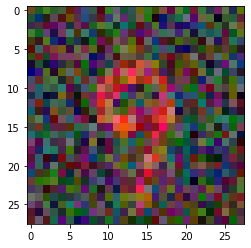

In [55]:
test_model()

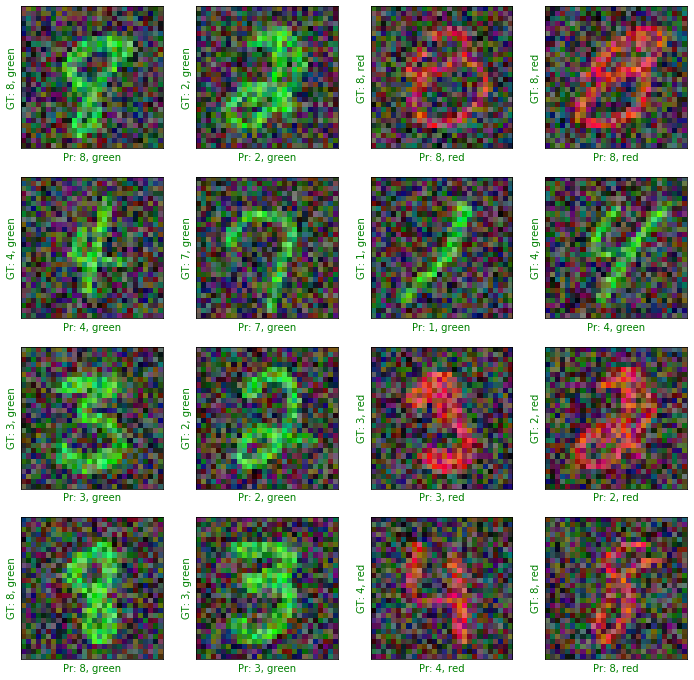

In [57]:
plt.figure(figsize=(12,12))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    test_model(show=False)
plt.show()